## Model Metrics Analysis for LLaMa-2 benchmarking

In [3]:
import glob
import time
import json
import copy
import asyncio
import logging
import itertools
import sagemaker
import numpy as np
import pandas as pd
import seaborn as sns
from globals import *
from datetime import datetime
from typing import Dict, List
from transformers import AutoTokenizer
from sagemaker.predictor import Predictor
from utils import load_config, count_tokens
from sagemaker.serializers import JSONSerializer

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 10, 6

In [5]:
# global constants
!pygmentize globals.py

import os
import yaml
from enum import Enum
from pathlib import Path

CONFIG_FILE: str = "config.yml"
with open(CONFIG_FILE, 'r') as file:
    config = yaml.safe_load(file)

DATA_DIR: str = "data"
PROMPTS_DIR = os.path.join(DATA_DIR, "prompts")
METRICS_DIR = os.path.join(DATA_DIR, "metrics", config['general']['name'])
METRICS_PER_INFERENCE_DIR  = os.path.join(METRICS_DIR, "per_inference")
METRICS_PER_CHUNK_DIR  = os.path.join(METRICS_DIR, "per_chunk")
MODELS_DIR = os.path.join(DATA_DIR, "models", config['general']['name'])
DATASET_DIR = os.path.join(DATA_DIR, "dataset")
SCRIPTS_DIR: str = "scripts"
DIR_LIST = [DATA_DIR, PROMPTS_DIR, METRICS_DIR, MODELS_DIR, DATASET_DIR, METRICS_PER_INFERENCE_DIR, METRICS_PER_CHUNK_DIR]
TOKENIZER_DIR = 'llama2_tokenizer'

_ = list(map(lambda x: os.makedirs(x, exist_ok=True), DIR_LIST))

ENDPOINT_LIST_FPATH:str = os.path.join(MODELS_DIR, "endpoints.json")
REQUEST_PAYLOAD_FPATH:str = os.path.join(PROMPTS_DIR, "payload.jsonl")
RESULTS_FPATH:str = os.path.j

In [6]:
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

In [7]:
config = load_config(CONFIG_FILE)
logger.info(json.dumps(config, indent=2))

[2024-01-18 21:31:48,230] p24 {635462509.py:2} INFO - {
  "general": {
    "name": "llama2-70b-inf2-g5-p4d"
  },
  "aws": {
    "region": "us-east-1",
    "sagemaker_execution_role": "arn:aws:iam::015469603702:role/SageMakerRepoRole"
  },
  "prompt": {
    "template_file": "prompt_template.txt",
    "all_prompts_file": "all_prompts.csv"
  },
  "datasets": [
    {
      "language": "en",
      "min_length_in_tokens": 1,
      "max_length_in_tokens": 500,
      "payload_file": "payload_{lang}_{min}-{max}.jsonl"
    },
    {
      "language": "en",
      "min_length_in_tokens": 500,
      "max_length_in_tokens": 1000,
      "payload_file": "payload_{lang}_{min}-{max}.jsonl"
    },
    {
      "language": "en",
      "min_length_in_tokens": 1000,
      "max_length_in_tokens": 2000,
      "payload_file": "payload_{lang}_{min}-{max}.jsonl"
    },
    {
      "language": "en",
      "min_length_in_tokens": 2000,
      "max_length_in_tokens": 3000,
      "payload_file": "payload_{lang}_{min}-{

In [8]:
fpath: str = os.path.join(METRICS_DIR, config["results"]["per_inference_request_file"])
df_per_inference = pd.read_csv(fpath)
    
logger.info(f"{fpath} read into dataframe of shape {df_per_inference.shape}")
df_per_inference.head()



[2024-01-18 21:31:48,526] p24 {298356999.py:4} INFO - data/metrics/llama2-70b-inf2-g5-p4d/per_inference_request_results.csv read into dataframe of shape (616, 19)


,endpoint_name,prompt,do_sample,temperature,top_p,top_k,max_new_tokens,truncate,completion,prompt_tokens,completion_tokens,latency,experiment_name,concurrency,instance_type,EndpointName,ModelName,Image,S3Uri
0,huggingface-pytorch-tgi-inference-2024-01-18-1...,<s>[INST] <<SYS>>\nYou are an assistant for qu...,True,0.7,0.92,120,100,2369,<s>[INST] <<SYS>>\nYou are an assistant for qu...,2369,2469,5.434374,llama2-70b-p4d.24xlarge-tgi-inference-2.0.1-tg...,1,ml.p4d.24xlarge,huggingface-pytorch-tgi-inference-2024-01-18-1...,huggingface-pytorch-tgi-inference-2024-01-18-1...,763104351884.dkr.ecr.us-east-1.amazonaws.com/h...,NaN
1,huggingface-pytorch-tgi-inference-2024-01-18-1...,<s>[INST] <<SYS>>\nYou are an assistant for qu...,True,0.7,0.92,120,100,2062,<s>[INST] <<SYS>>\nYou are an assistant for qu...,2062,2162,6.374595,llama2-70b-p4d.24xlarge-tgi-inference-2.0.1-tg...,2,ml.p4d.24xlarge,huggingface-pytorch-tgi-inference-2024-01-18-1...,huggingface-pytorch-tgi-inference-2024-01-18-1...,763104351884.dkr.ecr.us-east-1.amazonaws.com/h...,NaN
2,huggingface-pytorch-tgi-inference-2024-01-18-1...,<s>[INST] <<SYS>>\nYou are an assistant for qu...,True,0.7,0.92,120,100,2333,<s>[INST] <<SYS>>\nYou are an assistant for qu...,2333,2336,1.718784,llama2-70b-p4d.24xlarge-tgi-inference-2.0.1-tg...,4,ml.p4d.24xlarge,huggingface-pytorch-tgi-inference-2024-01-18-1...,huggingface-pytorch-tgi-inference-2024-01-18-1...,763104351884.dkr.ecr.us-east-1.amazonaws.com/h...,NaN
3,llama-2-70b-g5-48xlarge-1705605987,<s>[INST] <<SYS>>\nYou are an assistant for qu...,True,0.7,0.92,120,100,1910,Passage:\nYou are an assistant for question-a...,1910,102,18.008977,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,2,ml.g5.48xlarge,llama-2-70b-g5-48xlarge-1705605987,meta-textgeneration-llama-2-70b-2024-01-18-19-...,763104351884.dkr.ecr.us-east-1.amazonaws.com/h...,s3://jumpstart-private-cache-prod-us-east-1/me...
4,huggingface-pytorch-tgi-inference-2024-01-18-1...,<s>[INST] <<SYS>>\nYou are an assistant for qu...,True,0.7,0.92,120,100,3003,<s>[INST] <<SYS>>\nYou are an assistant for qu...,3003,3011,2.974069,llama2-70b-p4d.24xlarge-tgi-inference-2.0.1-tg...,2,ml.p4d.24xlarge,huggingface-pytorch-tgi-inference-2024-01-18-1...,huggingface-pytorch-tgi-inference-2024-01-18-1...,763104351884.dkr.ecr.us-east-1.amazonaws.com/h...,NaN


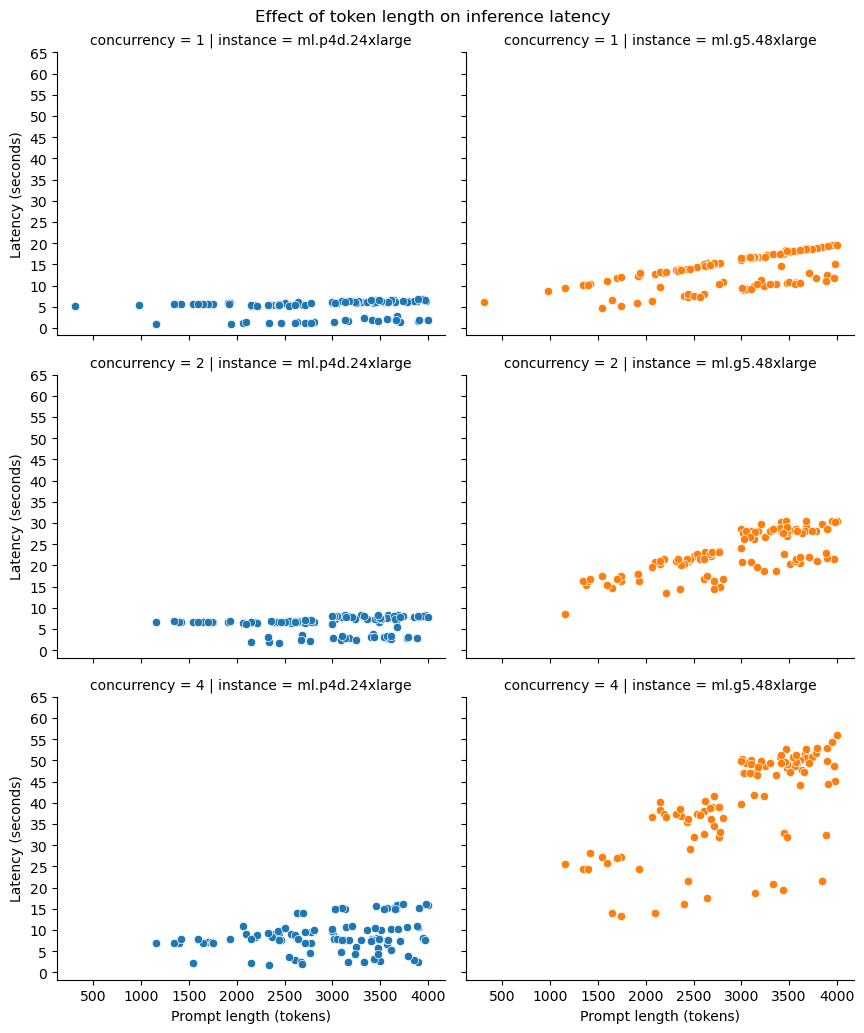

In [9]:

df_per_inference = df_per_inference.rename(columns={"instance_type": "instance"})



g = sns.FacetGrid(df_per_inference, col="instance", row="concurrency", hue="instance", height=3.5, aspect=1.25)
g.fig.suptitle("Effect of token length on inference latency")
sns_plot = g.map(sns.scatterplot, "prompt_tokens", "latency")
g = g.set_ylabels("Latency (seconds)")
yticks: List = list(range(0, (int(df_per_inference.latency.max())//10+2)*10, 5))
g = g.set(yticks=yticks)
g = g.set_xlabels("Prompt length (tokens)")

fpath: str = os.path.join(METRICS_DIR, TOKENS_VS_LATENCY_PLOT_FNAME)
sns_plot.savefig(fpath)
sns_plot


In [10]:
all_metrics_fpath: str = os.path.join(METRICS_DIR, config["results"]["all_metrics_file"])

df_all_metrics = pd.read_csv(all_metrics_fpath)
logger.info(f"{all_metrics_fpath} contains {df_all_metrics.shape[0]} results")
df_all_metrics.head()

[2024-01-18 21:31:50,843] p24 {793450579.py:4} INFO - data/metrics/llama2-70b-inf2-g5-p4d/all_metrics.csv contains 364 results


,experiment_name,concurrency,payload_file,errors,successes,error_rate,all_prompts_token_count,prompt_token_count_mean,prompt_token_throughput,all_completions_token_count,...,completion_token_throughput,transactions,transactions_per_second,transactions_per_minute,latency_mean,instance_type,EndpointName,ModelName,Image,S3Uri
0,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,1,payload_en_2000-3000.jsonl,[],1,0.0,2213,2213.0,166.73,102,...,7.68,1,0.08,4,13.256712,ml.g5.48xlarge,llama-2-70b-g5-48xlarge-1705605987,meta-textgeneration-llama-2-70b-2024-01-18-19-...,763104351884.dkr.ecr.us-east-1.amazonaws.com/h...,s3://jumpstart-private-cache-prod-us-east-1/me...
1,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,4,payload_en_3000-4000.jsonl,[],4,0.0,14034,3508.5,275.51,311,...,6.11,4,0.08,4,48.470149,ml.g5.48xlarge,llama-2-70b-g5-48xlarge-1705605987,meta-textgeneration-llama-2-70b-2024-01-18-19-...,763104351884.dkr.ecr.us-east-1.amazonaws.com/h...,s3://jumpstart-private-cache-prod-us-east-1/me...
2,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,2,payload_en_3000-4000.jsonl,[],2,0.0,7630,3815.0,249.28,204,...,6.66,2,0.07,4,30.574534,ml.g5.48xlarge,llama-2-70b-g5-48xlarge-1705605987,meta-textgeneration-llama-2-70b-2024-01-18-19-...,763104351884.dkr.ecr.us-east-1.amazonaws.com/h...,s3://jumpstart-private-cache-prod-us-east-1/me...
3,llama2-70b-p4d.24xlarge-tgi-inference-2.0.1-tg...,1,payload_en_3000-4000.jsonl,[],1,0.0,3400,3400.0,517.59,3499,...,532.66,1,0.15,9,6.541840,ml.p4d.24xlarge,huggingface-pytorch-tgi-inference-2024-01-18-1...,huggingface-pytorch-tgi-inference-2024-01-18-1...,763104351884.dkr.ecr.us-east-1.amazonaws.com/h...,NaN
4,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,1,payload_en_2000-3000.jsonl,[],1,0.0,2624,2624.0,179.15,102,...,6.96,1,0.07,4,14.622259,ml.g5.48xlarge,llama-2-70b-g5-48xlarge-1705605987,meta-textgeneration-llama-2-70b-2024-01-18-19-...,763104351884.dkr.ecr.us-east-1.amazonaws.com/h...,s3://jumpstart-private-cache-prod-us-east-1/me...


In [11]:
df_all_metrics.columns

Index(['experiment_name', 'concurrency', 'payload_file', 'errors', 'successes',
       'error_rate', 'all_prompts_token_count', 'prompt_token_count_mean',
       'prompt_token_throughput', 'all_completions_token_count',
       'completion_token_count_mean', 'completion_token_throughput',
       'transactions', 'transactions_per_second', 'transactions_per_minute',
       'latency_mean', 'instance_type', 'EndpointName', 'ModelName', 'Image',
       'S3Uri'],
      dtype='object')

In [12]:
experiments = df_all_metrics.experiment_name.unique()
instance_types = df_all_metrics.instance_type.unique()
model_names = df_all_metrics.ModelName.unique()
logger.info(f"contains information about {len(experiments)} experiments, {len(instance_types)} instance types, {len(model_names)} models")

[2024-01-18 21:31:54,419] p24 {369708136.py:4} INFO - contains information about 2 experiments, 2 instance types, 2 models


In [13]:
relevant_cols = ['experiment_name',
                   'payload_file',
                     'instance_type',
                       'concurrency',
                         'error_rate',
                           'prompt_token_count_mean',
                             'prompt_token_throughput',
                               'completion_token_count_mean',
                                 'completion_token_throughput',
                                   'latency_mean',
                                     'transactions_per_minute']
group_by_cols = ['experiment_name',
                   'payload_file',
                     'instance_type',
                      'concurrency']


In [14]:
COUNTS_FNAME: str = "experiment_counts.csv"
fpath: str = os.path.join(METRICS_DIR, COUNTS_FNAME)
df_counts = df_all_metrics[group_by_cols].value_counts().reset_index()
df_counts.to_csv(fpath, index=False)
df_counts

,experiment_name,payload_file,instance_type,concurrency,count
0,llama2-70b-p4d.24xlarge-tgi-inference-2.0.1-tg...,payload_en_3000-4000.jsonl,ml.p4d.24xlarge,1,57
1,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_3000-4000.jsonl,ml.g5.48xlarge,1,57
2,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_2000-3000.jsonl,ml.g5.48xlarge,1,32
3,llama2-70b-p4d.24xlarge-tgi-inference-2.0.1-tg...,payload_en_2000-3000.jsonl,ml.p4d.24xlarge,1,32
4,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_3000-4000.jsonl,ml.g5.48xlarge,2,28
5,llama2-70b-p4d.24xlarge-tgi-inference-2.0.1-tg...,payload_en_3000-4000.jsonl,ml.p4d.24xlarge,2,28
6,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_2000-3000.jsonl,ml.g5.48xlarge,2,16
7,llama2-70b-p4d.24xlarge-tgi-inference-2.0.1-tg...,payload_en_2000-3000.jsonl,ml.p4d.24xlarge,2,16
8,llama2-70b-p4d.24xlarge-tgi-inference-2.0.1-tg...,payload_en_1000-2000.jsonl,ml.p4d.24xlarge,1,15
9,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_1000-2000.jsonl,ml.g5.48xlarge,1,15


In [15]:
ERROR_RATES_FNAME: str = "error_rates.csv"
fpath: str = os.path.join(METRICS_DIR, ERROR_RATES_FNAME)
df_error_rates = df_all_metrics.groupby(group_by_cols).agg({'error_rate': 'mean'}).reset_index()
df_error_rates = df_error_rates.round(2)
df_error_rates.to_csv(fpath, index=False)
df_error_rates


,experiment_name,payload_file,instance_type,concurrency,error_rate
0,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_1-500.jsonl,ml.g5.48xlarge,1,0.0
1,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_1000-2000.jsonl,ml.g5.48xlarge,1,0.0
2,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_1000-2000.jsonl,ml.g5.48xlarge,2,0.0
3,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_1000-2000.jsonl,ml.g5.48xlarge,4,0.0
4,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_2000-3000.jsonl,ml.g5.48xlarge,1,0.0
5,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_2000-3000.jsonl,ml.g5.48xlarge,2,0.0
6,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_2000-3000.jsonl,ml.g5.48xlarge,4,0.0
7,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_3000-4000.jsonl,ml.g5.48xlarge,1,0.0
8,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_3000-4000.jsonl,ml.g5.48xlarge,2,0.0
9,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_3000-4000.jsonl,ml.g5.48xlarge,4,0.0


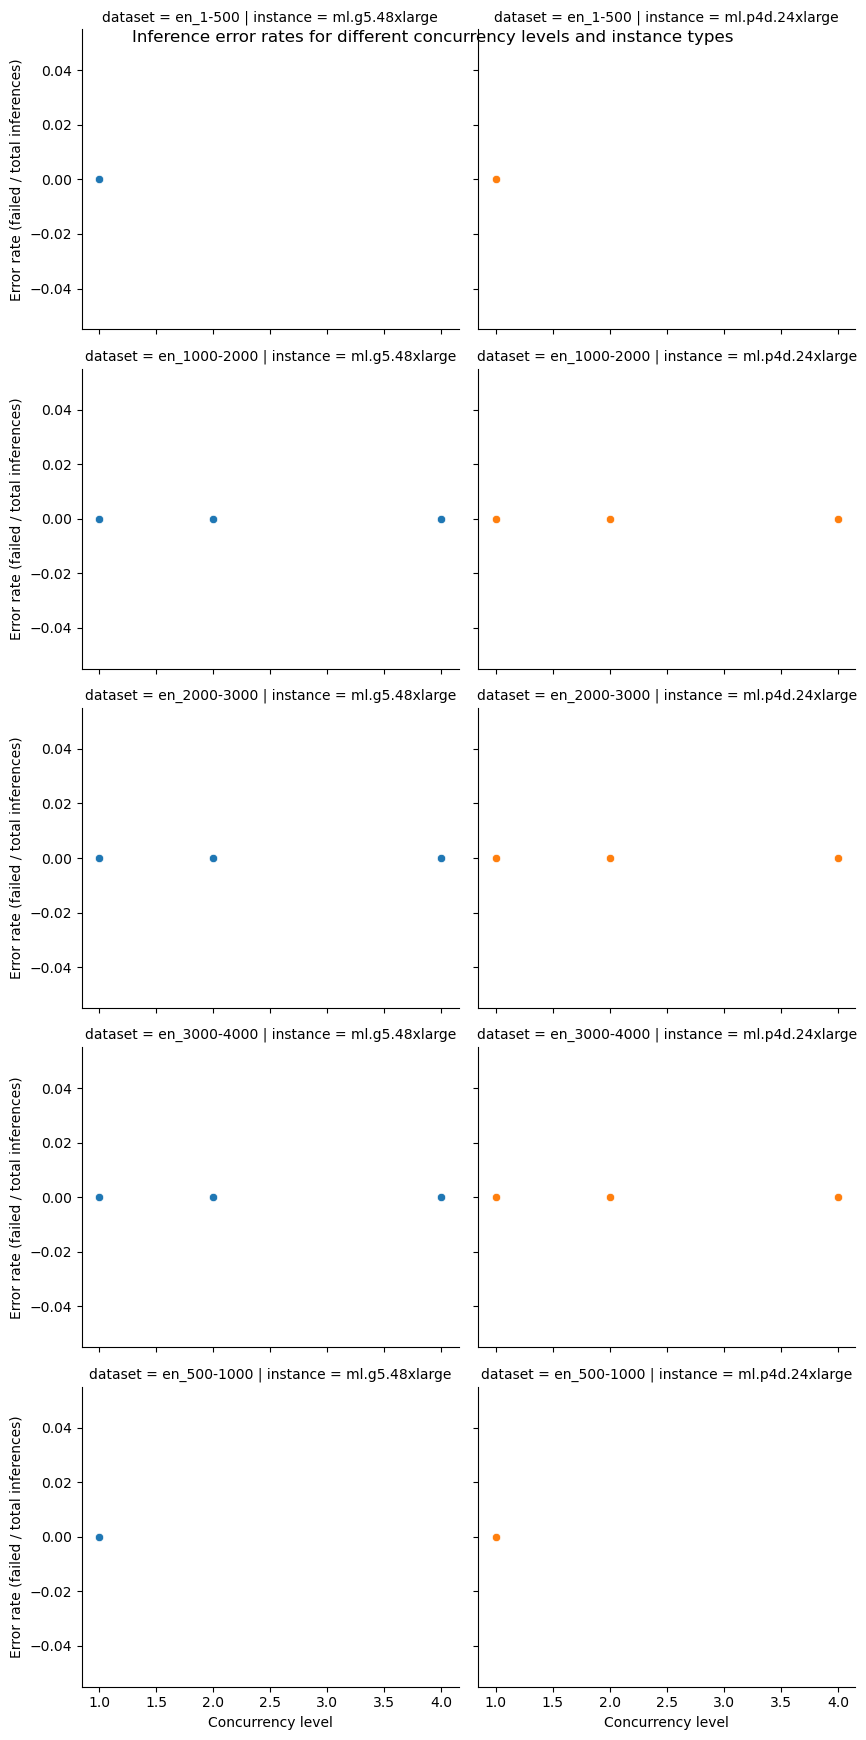

In [16]:
df_error_rates = df_error_rates.rename(columns={"instance_type": "instance", "payload_file": "dataset"})
df_error_rates.dataset = df_error_rates.dataset.map(lambda x: x.replace(".jsonl", "").replace("payload_", ""))

g = sns.FacetGrid(df_error_rates, col="instance", row="dataset", hue="instance", height=3.5, aspect=1.25)
sns_plot = g.map(sns.scatterplot, "concurrency", "error_rate")

g.fig.suptitle("Inference error rates for different concurrency levels and instance types")
g = g.set_ylabels("Error rate (failed / total inferences)")
g = g.set_xlabels("Concurrency level")


fpath: str = os.path.join(METRICS_DIR, ERROR_RATES_PLOT_FNAME)
sns_plot.savefig(fpath)
sns_plot

In [17]:
df_error_rates_nz = df_error_rates[df_error_rates.error_rate > 0]
df_error_rates_nz

,experiment_name,dataset,instance,concurrency,error_rate


In [18]:
df_summary_metrics = df_all_metrics[relevant_cols].groupby(group_by_cols).mean().reset_index()

# ugly way of doing this, will refactor this later (maybe)
df_summary_metrics.fillna(PLACE_HOLDER, inplace=True)
int_cols = ['prompt_token_count_mean', 'prompt_token_throughput', 'completion_token_count_mean', 'completion_token_throughput', 'transactions_per_minute']
for ic in int_cols:
    df_summary_metrics[ic] = df_summary_metrics[ic].astype(int)

df_summary_metrics.replace(PLACE_HOLDER, np.nan, inplace=True)
df_summary_metrics.latency_mean	= df_summary_metrics.latency_mean.round(2)
df_summary_metrics.error_rate	= df_summary_metrics.error_rate.round(2)

fpath: str = all_metrics_fpath.replace("all_metrics", "all_metrics_summary")
df_summary_metrics.to_csv(fpath, index=False)
df_summary_metrics

,experiment_name,payload_file,instance_type,concurrency,error_rate,prompt_token_count_mean,prompt_token_throughput,completion_token_count_mean,completion_token_throughput,latency_mean,transactions_per_minute
0,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_1-500.jsonl,ml.g5.48xlarge,1,0.0,304,47,102,15,6.19,9
1,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_1000-2000.jsonl,ml.g5.48xlarge,1,0.0,1623,185,78,7,9.67,6
2,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_1000-2000.jsonl,ml.g5.48xlarge,2,0.0,1600,194,95,11,16.00,6
3,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_1000-2000.jsonl,ml.g5.48xlarge,4,0.0,1548,233,85,12,23.84,8
4,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_2000-3000.jsonl,ml.g5.48xlarge,1,0.0,2503,214,75,5,12.47,4
5,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_2000-3000.jsonl,ml.g5.48xlarge,2,0.0,2503,230,78,7,20.15,5
6,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_2000-3000.jsonl,ml.g5.48xlarge,4,0.0,2503,259,72,7,34.28,6
7,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_3000-4000.jsonl,ml.g5.48xlarge,1,0.0,3478,243,66,3,15.16,3
8,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_3000-4000.jsonl,ml.g5.48xlarge,2,0.0,3482,256,75,5,26.30,4
9,llama2-70b-g5.48xlarge-huggingface-pytorch-tgi...,payload_en_3000-4000.jsonl,ml.g5.48xlarge,4,0.0,3482,272,81,6,46.14,4


In [19]:
df_summary_metrics_nz = df_summary_metrics[df_summary_metrics.error_rate == 0]
logger.info(f"there are {len(df_summary_metrics_nz)} entries out of {len(df_summary_metrics)} in the summary data for which error rate is 0")

[2024-01-18 21:31:59,485] p24 {3483828648.py:2} INFO - there are 22 entries out of 22 in the summary data for which error rate is 0


In [20]:

from typing import Optional
dttm = str(datetime.utcnow())
#RESULT_ROW: str = "|`{dataset}`|`{instance_type}`|{desc}|"
#RESULT_DESC: str = """The best option for staying within a latency budget of `{latency_budget} seconds` on a `{instance_type}` for the `{dataset}` dataset is a `concurrency level of {concurrency}`. A concurrency level of {concurrency} achieves an `average latency of {latency_mean} seconds`, for an `average prompt size of {prompt_size} tokens` and `completion size of {completion_size} tokens` with `{tpm} transactions/minute`."""

overall_results_md = OVERALL_RESULTS_MD.format(dttm=dttm)
results_group_cols: List[str] = ['instance_type', 'payload_file']
result_rows: List[str] = []
for row in df_summary_metrics[results_group_cols].drop_duplicates().iterrows():
    instance_type = row[1]['instance_type']
    dataset = row[1]['payload_file']
    df_summary_metrics_nz_subset = df_summary_metrics_nz[(df_summary_metrics_nz.instance_type == instance_type) &
                                                          (df_summary_metrics_nz.payload_file == dataset) &
                                                           (df_summary_metrics_nz.latency_mean <= LATENCY_BUDGET)]
    num_results = df_summary_metrics_nz_subset.shape[0]
    result_row: Optional[str] = None
    if num_results > 0:
        logger.info(f"there are {num_results} options to choose the best option from for instance_type={instance_type}, dataset={dataset}")
        df_summary_metrics_nz_subset_selected = df_summary_metrics_nz_subset[df_summary_metrics_nz_subset.concurrency == df_summary_metrics_nz_subset.concurrency.max()]
        best = df_summary_metrics_nz_subset_selected.to_dict(orient='records')[0]
        # logger.info(best)
        result_desc = RESULT_DESC.format(latency_budget=LATENCY_BUDGET,
                           instance_type=best['instance_type'],
                           dataset=dataset,
                           concurrency=best['concurrency'],
                           latency_mean=best['latency_mean'],
                           prompt_size=int(best['prompt_token_count_mean']),
                           completion_size=int(best['completion_token_count_mean']),
                           tpm=int(best['transactions_per_minute']))     
        
        # logger.info(result_desc)
    else:
        logger.info(f"there are NO options to choose from for instance_type={instance_type}, dataset={dataset}")
        result_desc = RESULT_FAILURE_DESC.format(latency_budget=LATENCY_BUDGET,
                           instance_type=best['instance_type'],
                           dataset=dataset)
    result_row: str = RESULT_ROW.format(instance_type=best['instance_type'],
                                        dataset=dataset,
                                        desc=result_desc)
    result_rows.append(result_row)
        
    
    #logger.info(f"instance_type={row[0]}, payload_file={row[1]}")
overall_results_md += "\n".join(result_rows)
logger.info(overall_results_md)



[2024-01-18 21:31:59,590] p24 {3483931720.py:18} INFO - there are 1 options to choose the best option from for instance_type=ml.g5.48xlarge, dataset=payload_en_1-500.jsonl
[2024-01-18 21:31:59,597] p24 {3483931720.py:18} INFO - there are 2 options to choose the best option from for instance_type=ml.g5.48xlarge, dataset=payload_en_1000-2000.jsonl
[2024-01-18 21:31:59,604] p24 {3483931720.py:18} INFO - there are 1 options to choose the best option from for instance_type=ml.g5.48xlarge, dataset=payload_en_2000-3000.jsonl
[2024-01-18 21:31:59,609] p24 {3483931720.py:18} INFO - there are 1 options to choose the best option from for instance_type=ml.g5.48xlarge, dataset=payload_en_3000-4000.jsonl
[2024-01-18 21:31:59,616] p24 {3483931720.py:18} INFO - there are 1 options to choose the best option from for instance_type=ml.g5.48xlarge, dataset=payload_en_500-1000.jsonl
[2024-01-18 21:31:59,623] p24 {3483931720.py:18} INFO - there are 1 options to choose the best option from for instance_type=

In [21]:
OVERALL_RESULTS_PLOTS_MD: str = """

## Plots

The following plots provide insights into the results from the different experiments run.

![{plot1_text}]({plot1_fname})

![{plot2_text}]({plot2_fname})
"""

overall_results_plots_md: str = OVERALL_RESULTS_PLOTS_MD.format(plot1_text=ERROR_RATES_PLOT_TEXT, 
                                                                plot1_fname=ERROR_RATES_PLOT_FNAME,
                                                                plot2_text=TOKENS_VS_LATENCY_PLOT_TEXT, 
                                                                plot2_fname=TOKENS_VS_LATENCY_PLOT_FNAME)

overall_results_md += overall_results_plots_md

In [22]:
fpath: str = os.path.join(METRICS_DIR, RESULTS_DESC_MD_FNAME)
logger.info(f"going to write overall results description to {fpath}")
Path(fpath).write_text(overall_results_md)

[2024-01-18 21:31:59,766] p24 {3574979679.py:2} INFO - going to write overall results description to data/metrics/llama2-70b-inf2-g5-p4d/results.md


4536